In [1]:
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from utils.generators import UserGenerator

In [146]:
ug = UserGenerator()

In [147]:
dat = ug.generate_lift_data(1000,0.1,0.5,1)

In [148]:
# extract and sort by time

dat['hour'] = dat.datetime.dt.hour

dat = dat.reset_index()[['user_id','datetime','purchased','hour']]

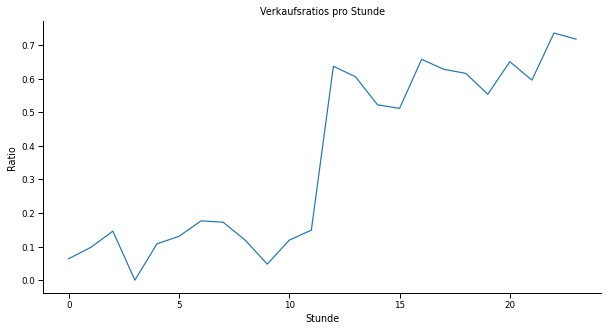

In [149]:
fig = plt.figure(figsize=(10,5))
sns.set_context("paper")
ax = sns.lineplot( data=dat.groupby('hour')['purchased'].mean() )
ax.set_title("Verkaufsratios pro Stunde")
ax.set(xlabel='Stunde', ylabel='Ratio')
sns.despine()

In [150]:
dat.sample(10)

,user_id,datetime,purchased,hour
242,uid_5988,2020-01-01 05:41:07,0,5
932,uid_6766,2020-01-01 22:35:42,1,22
906,uid_6283,2020-01-01 21:44:23,1,21
374,uid_6210,2020-01-01 09:15:06,0,9
863,uid_6566,2020-01-01 20:45:59,1,20
754,uid_6483,2020-01-01 18:32:15,0,18
810,uid_6052,2020-01-01 19:49:47,1,19
611,uid_6285,2020-01-01 15:16:44,0,15
778,uid_6568,2020-01-01 19:12:25,1,19
228,uid_6426,2020-01-01 05:20:32,0,5


In [151]:
with pm.Model() as model:
    
    lambda_1 = pm.Uniform("lambda_1",  lower=0, upper=1)
    lambda_2 = pm.Uniform("lambda_2",  lower=0, upper=1)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=dat.shape[0] - 1)
    
    # to be able to tell the index point of change we need to add an index
    index = np.arange(dat.shape[0])
    
    # a switch to find the point of interest
    lambda_ = pm.math.switch(tau > index, lambda_1, lambda_2)
    
    observation = pm.Binomial("obs", p=lambda_, n=dat.shape[0], observed=dat.purchased)

    # initializer 
    start = pm.find_MAP()
    # NUTS sampler
    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000, step=step, discard_tuned_samples=True)

logp = -769.63, ||grad|| = 225.46: 100%|██████████| 21/21 [00:00<00:00, 3553.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5503.93draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [152]:
#len(trace['tau'])

In [153]:
tau_post = trace['tau'][:5000]

lambda_1 = trace['lambda_1'][:5000] * dat.shape[0]
lambda_2 = trace['lambda_2'][:5000] * dat.shape[0]


Clean up the date time inference

/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


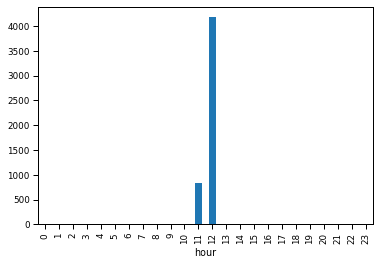

In [154]:
dat_time = dat[['hour']]
dat_time['posterior_split'] = dat_time.index.to_series().map(Counter(tau_post))
dat_time.groupby('hour')['posterior_split'].sum().plot(kind='bar')

In [174]:
# convert the tau values to hourly

idx_2_hour = dat[['hour']].to_dict()['hour']
tau_post_hour = [idx_2_hour[t] for t in tau_post]

tau_post_hour = np.asarray(tau_post_hour)

[Text(0, 0.5, 'Relative Häufigkeit'), Text(0.5, 0, 'Index')]

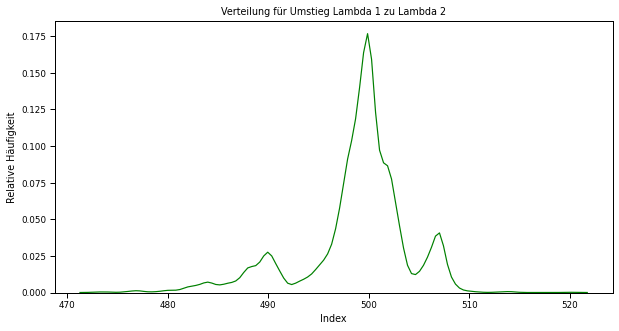

In [187]:
fig = plt.figure(figsize=(10,5))
ax = sns.distplot(tau_post, color='g', hist=False)
ax.set_title("Verteilung für Umstieg Lambda 1 zu Lambda 2")
ax.set(xlabel='Index', ylabel='Relative Häufigkeit')

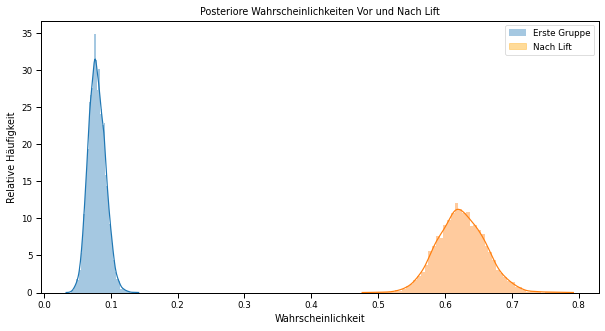

In [71]:

fig = plt.figure(figsize=(10,5))
ax = sns.distplot(lambda_1)
sns.distplot(lambda_2)
ax.set_title("Posteriore Wahrscheinlichkeiten Vor und Nach Lift")
ax.set(xlabel='Wahrscheinlichkeit', ylabel='Relative Häufigkeit')
legend = ax.legend(labels=["Erste Gruppe","Nach Lift"])
legend.legendHandles[1].set_color('orange')
